In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

import numpy as np
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from collections import Counter


from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
%matplotlib inline

In [3]:
# Download nltk resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/vlad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vlad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df =  pd.read_csv('data/SMSSpamCollection', sep = '\t', names = ["label", "message"])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

/home/vlad/anaconda3/envs/ml_labs/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Non-spam and spam data distribution')

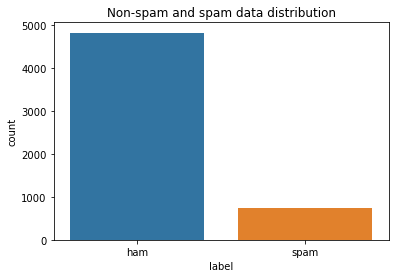

In [7]:
sns.countplot(df.label)
plt.title('Non-spam and spam data distribution')

In [8]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1}).astype(int)
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df_ham = df[df['label']==0].copy()
df_spam = df[df['label']==1].copy()

In [10]:
def generate_wordcloud(df_class, name):
    text = ' '.join(df_class['message'].astype(str).tolist())
    stopwords = set(STOPWORDS)
    
    fig_wordcloud = WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(name, fontsize=20 )
    plt.show()

In [11]:
df_ham

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
6,0,Even my brother is not like to speak with me. ...
...,...,...
5565,0,Huh y lei...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


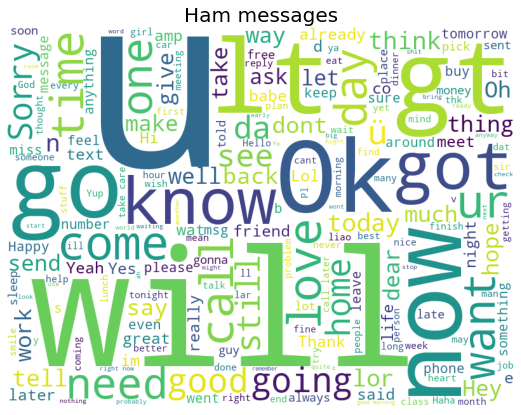

In [12]:
generate_wordcloud(df_ham, "Ham messages")

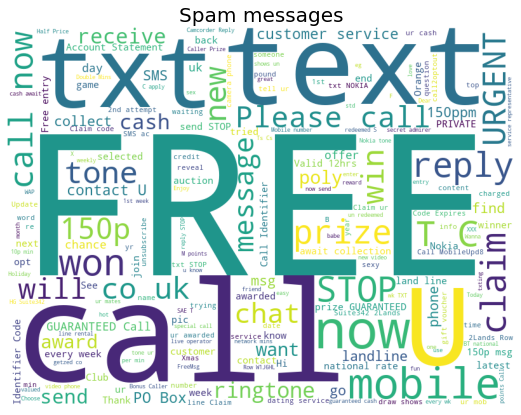

In [13]:
generate_wordcloud(df_spam, "Spam messages")

# Text preprocessing 

In [14]:
def clean_message(msgs, pos):
    """ 
    Clean the message
    1.Remove all non-words
    2.transform words into lower case
    3.remove stop words
    4.optionally perform stemming/lemmatization
    """
    msgs = re.sub("[^A-Za-z]", " ", msgs)
    msgs = msgs.lower()
    msgs = nltk.word_tokenize(msgs)
    lemmatizer = WordNetLemmatizer()
    msgs = [lemmatizer.lemmatize(msg,pos) for msg in msgs if not msg in stopwords.words('english')]
    
    #stemmer = PorterStemmer()
    #msgs = [stemmer.stem(msg) for msg in msgs if not msg in stopwords.words('english')]
    
    msgs = " ".join([item for item in msgs if len(item) > 1])
    return msgs

In [15]:
msgs = df.message[0]
print(msgs)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [16]:
cleaned_msg = clean_message(msgs, pos = wordnet.VERB)
print(cleaned_msg)

go jurong point crazy available bugis great world la buffet cine get amore wat


In [17]:
corpus = []

for i in range(0, len(df)):
    msgs = clean_message(df.message[i], pos = wordnet.VERB)
    corpus.append(msgs)

In [18]:
corpus[:4]

['go jurong point crazy available bugis great world la buffet cine get amore wat',
 'ok lar joke wif oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate apply',
 'dun say early hor already say']

In [19]:
df_new = pd.DataFrame({'Label':df['label'], 'message': corpus})

In [20]:
df_new.head()

,Label,message
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joke wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah think go usf live around though


# Bag of words features

In [21]:
cv = CountVectorizer()

X = cv.fit_transform(corpus).toarray()

y = df_new['Label']

In [22]:
print(X.shape, y.shape)

(5572, 6653) (5572,)


In [23]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 0)
X_train, y_train = X, y

In [24]:
# Number of unique word counts in sentences 
np.unique(X_train)

array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 15, 18])

In [25]:
pca = PCA(n_components=2)
X_train_centered = X_train - X_train.mean(axis=0)
pca.fit(X_train_centered)
X_pca = pca.transform(X_train_centered)

In [26]:
X_pca.shape

(5572, 2)

In [27]:
X_pca

array([[-0.05969828, -0.35688623],
       [-0.10447648, -0.16873354],
       [-0.13013602,  0.47186922],
       ...,
       [-0.09048227, -0.11133749],
       [-0.05237757,  0.13013057],
       [-0.07059417, -0.11037265]])

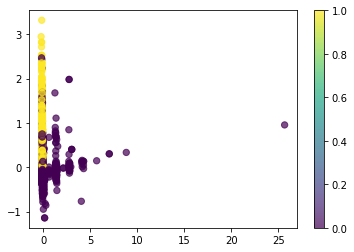

In [28]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.7, s=40)
plt.colorbar()

# Bag of words models - KMeans, AgglomerativeClustering, GaussianMixture

In [29]:
bow_kmeans_model = KMeans(n_clusters=2, init='k-means++', n_init=100)
y_predicted = bow_kmeans_model.fit_predict(X_pca)

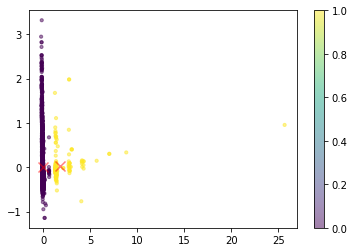

In [30]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = bow_kmeans_model.cluster_centers_
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [31]:
bow_agllomerative_model = AgglomerativeClustering(n_clusters=2, linkage="average", affinity="cosine")
y_predicted = bow_agllomerative_model.fit_predict(X_pca)

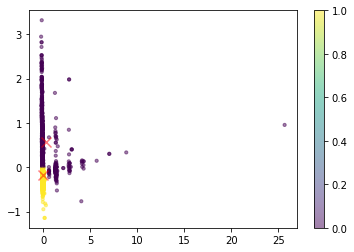

In [32]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_pca[y_predicted == 1], axis=0), np.mean(X_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [33]:
bow_birch_model = Birch(n_clusters=2)
y_predicted = bow_birch_model.fit_predict(X_pca)

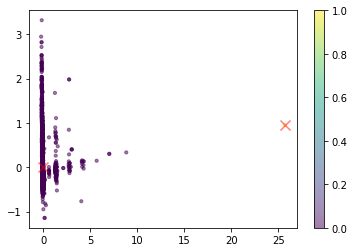

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_pca[y_predicted == 1], axis=0), np.mean(X_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [35]:
bow_gm_model = GaussianMixture(n_components=2)
y_predicted = bow_gm_model.fit_predict(X_pca)

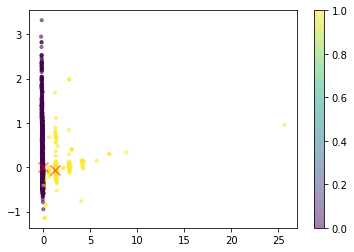

In [36]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_pca[y_predicted == 1], axis=0), np.mean(X_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [37]:
models = [bow_kmeans_model, bow_agllomerative_model, bow_birch_model]
data = []

for model in models:
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, model.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, model.labels_,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, model.labels_),
        'Completeness': metrics.completeness_score(y, model.labels_),
        'V-measure': metrics.v_measure_score(y, model.labels_),
        'Silhouette': metrics.silhouette_score(X_pca, model.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Agglomerative', "Birch"])

In [38]:
results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,-0.054290,0.021608,0.015836,0.035584,0.021918,0.811156
Agglomerative,0.484290,0.349172,0.412652,0.302808,0.349298,0.680571
Birch,-0.000303,-0.000227,0.000066,0.014956,0.000131,0.980839


## Term frequency inverse document frequency - TFIDF

In [39]:
tf_id = TfidfVectorizer()

X_tfidf = tf_id.fit_transform(corpus).toarray()
y_tfidf = y

In [40]:
pca = PCA(n_components=2)
X_tfidf_centered = X_tfidf - X_tfidf.mean(axis=0)
X_tfidf_pca = pca.fit_transform(X_tfidf_centered)

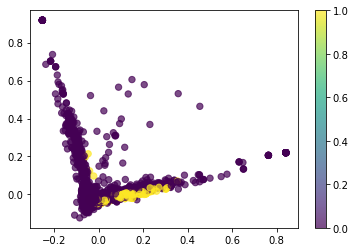

In [41]:
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_tfidf, alpha=0.7, s=40)
plt.colorbar()

In [42]:
tfidf_kmeans_model = KMeans(n_clusters=2, init='k-means++', n_init=100)
y_predicted = tfidf_kmeans_model.fit_predict(X_tfidf_pca)

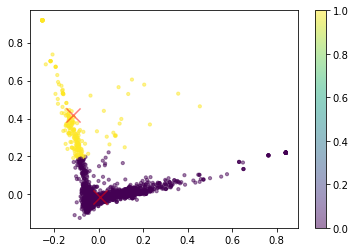

In [43]:
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

tfidf_pca_centers = tfidf_kmeans_model.cluster_centers_
# tfidf_pca_centers = pca.transform(tfidf_centers)
plt.scatter(tfidf_pca_centers[:, 0], tfidf_pca_centers[:, 1], c='red', s=200, alpha=0.5, marker="x")

plt.colorbar()

In [44]:
tfidf_aglomerative_cluster_model = AgglomerativeClustering(n_clusters=2, linkage="average", affinity="cosine")
y_predicted = tfidf_aglomerative_cluster_model.fit_predict(X_tfidf_pca)

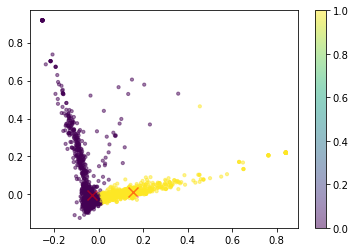

In [45]:
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_tfidf_pca[y_predicted == 1], axis=0), np.mean(X_tfidf_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [46]:
tfidf_birch_model = Birch(n_clusters=2, threshold=0.1)
y_predicted = tfidf_birch_model.fit_predict(X_tfidf_pca)

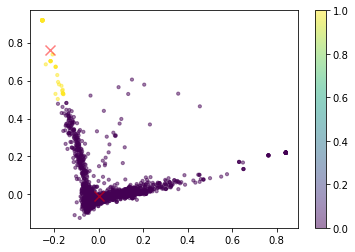

In [47]:
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_tfidf_pca[y_predicted == 1], axis=0), np.mean(X_tfidf_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [48]:
tfidf_gm_model = GaussianMixture(n_components=2)
y_predicted = tfidf_gm_model.fit_predict(X_tfidf_pca)

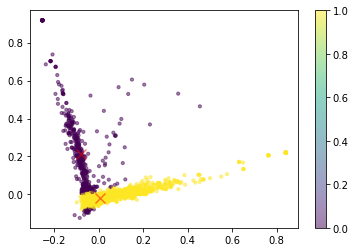

In [49]:
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=y_predicted, s=10, alpha=0.5)

pca_centers = np.stack([np.mean(X_tfidf_pca[y_predicted == 1], axis=0), np.mean(X_tfidf_pca[y_predicted == 0], axis=0)])
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, alpha=0.5, marker="x")

plt.colorbar()

In [50]:
models = [tfidf_kmeans_model, tfidf_aglomerative_cluster_model, tfidf_birch_model]
data = []

for model in models:
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, model.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, model.labels_,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, model.labels_),
        'Completeness': metrics.completeness_score(y, model.labels_),
        'V-measure': metrics.v_measure_score(y, model.labels_),
        'Silhouette': metrics.silhouette_score(X_pca, model.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Agglomerative', "Birch"])

In [51]:
results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,-0.046698,0.016188,0.011533,0.029049,0.016511,-0.348548
Agglomerative,0.328787,0.156906,0.168256,0.147306,0.157086,0.601554
Birch,-0.012919,0.004876,0.002963,0.024863,0.005295,-0.585806
